Импортируем нужные нам модули

In [65]:
# annotations for code readability
import typing as tp
import functools as ft
import chex

# data visualization and split
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# nn
import jax
from jax import numpy as jnp
from flax import nnx
import optax

from utils import (
    MLP,
    _init_metrics_hisory,
    _init_model,
    plot_metrics,
    batch
)

Загрузим данные (я сделал проще, правильный код закомментирован)

In [2]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df = pd.read_csv("iris.csv")
# df['class'] = le.fit_transform(df['class'])
# df['class'] = le.inverse_transform(df['class'])

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)


In [3]:
X_train.shape

(120, 4)

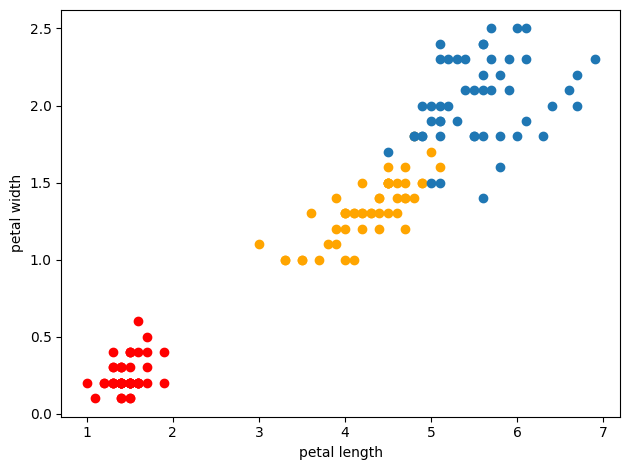

In [4]:
plt.scatter(X[y == 0][:,2:3], X[y == 0][:,3:], color='red')
plt.scatter(X[y == 1][:,2:3], X[y == 1][:,3:], color='orange')
plt.scatter(X[y == 2][:,2:3], X[y == 2][:,3:])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.tight_layout()

Создадим модель многослойного перцептрона

In [5]:
model = MLP(input_dim=4, hidden=(5,), output_dim=3, rngs=nnx.Rngs(42))
model 

MLP(
  nn=Sequential(
    layers=[Linear(
      kernel=Param(
        value=Array(shape=(4, 5), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(5,), dtype=float32)
      ),
      in_features=4,
      out_features=5,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x0000015F317813A0>,
      bias_init=<function zeros at 0x0000015F1EFC8C10>,
      dot_general=<function dot_general at 0x0000015F1EA31310>
    ), <PjitFunction of <function silu at 0x0000015F1EFDD310>>, Linear(
      kernel=Param(
        value=Array(shape=(5, 3), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(3,), dtype=float32)
      ),
      in_features=5,
      out_features=3,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x0000015F317813

Проверим работу модели

In [6]:
y = model(jnp.ones(4))
y

Array([ 0.08003473, -0.06023519,  0.14485066], dtype=float32)

В точности, как в инструкции)

Теперь создадим функции потерь, обучения и оценки модели

In [74]:
# @ft.partial(jax.jit, static_argnums=0)
def step(graphdef: nnx.GraphDef, # compile-time constant
         state: nnx.GraphState,  
         features: chex.ArrayBatched,
         labels: chex.ArrayBatched,
         train: bool
    ) -> nnx.GraphState:
    def loss_fn(
            model: MLP, 
            features: chex.ArrayBatched, 
            labels: chex.ArrayBatched
        ) -> tuple[chex.ArrayBatched]:
        """Computes CE-Loss with optax. Returns loss and logits"""
        logits = model(features)
        loss = jnp.mean(
            optax.softmax_cross_entropy_with_integer_labels(
                logits=logits, labels=labels
            )
        )
        return loss, logits

    def train_step(
            args: tuple[MLP, chex.ArrayBatched, nnx.Optimizer]
        ) -> tuple[chex.ArrayBatched]:
        model, features, labels, optimizer = args
        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(model, features, labels)
        optimizer.update(grads)
        return loss, logits
    
    def eval_step(
            args: tuple[MLP, chex.ArrayBatched, nnx.Optimizer]
        ) -> tuple[chex.ArrayBatched]:
        model, features, labels, _ = args
        return loss_fn(model, features, labels)
    
    model, optimizer, metrics = nnx.merge(graphdef, state)
    loss, logits = nnx.cond(
            train, 
            train_step,
            eval_step,
            (model, features, labels, optimizer)
        )
    metrics.update(loss=loss, logits=logits, labels=labels)
    _, state = nnx.split((model, optimizer, metrics))
    return state
    

Теперь создадим функции инициализации модели, оптимизатора и прогона обучения и оценки модели

In [11]:
def run(X_train: chex.ArrayNumpy,
        y_train: chex.ArrayNumpy,
        X_test: chex.ArrayNumpy,
        y_test: chex.ArrayNumpy,
        batch_size: int = 8,
        key: tp.Optional[chex.PRNGKey] = None,
        input_dim: int = 60,
        hidden: tp.Optional[tuple[int]] = None,
        output_dim: int = 1,
        num_epochs: int = 10) -> tuple[MLP, dict[str, chex.Array], nnx.State, nnx.State]:
    """Inits model and it's components and run train and test"""
    if key is None:
        key = jax.random.key(42)
    batch_key, model_key = jax.random.split(key)
    model_key = nnx.Rngs(model_key)
    # get model and default weights of the first layer
    model, before = _init_model(input_dim=input_dim, hidden=hidden, output_dim=output_dim, rngs=model_key)
    optimizer = nnx.Optimizer(model, optax.adamw(5e-3, 0.9))
    metrics_history = _init_metrics_hisory()
    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss'),
    )

    for i in range(num_epochs):
        # train
        model.train()
        graphdef, state = nnx.split((model, optimizer, metrics))

        # new order for shuffle
        batch_key = jax.random.split(batch_key)[0]
        for X_batched, y_batched in batch(X=X_train,
                                          y=y_train,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=True):
            state = step(graphdef=graphdef,
                         state=state,
                         features=X_batched, 
                         labels=y_batched,
                         train=True)

        # if flax >= 0.10.0
        # nnx.update((model, optimizer, metrics), state)
        
        
        # else
        model, optimizer, metrics = nnx.merge(graphdef, state)
        # store train metrics
        for metric, value in metrics.compute().items():     
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # eval
        model.eval()
        graphdef, state = nnx.split((model, optimizer, metrics))
        for X_batched, y_batched in batch(X=X_test, 
                                          y=y_test,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=False):
            state = step(graphdef=graphdef,
                         state=state,
                         features=X_batched, 
                         labels=y_batched,
                         train=False)
        
        # if flax >= 0.10.0
        # nnx.update((model, optimizer, metrics), state)
        
        # else
        model, optimizer, metrics = nnx.merge(graphdef, state)
        # store eval metrics
        for metric, value in metrics.compute().items():    
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset() 

        print(
            f"[train] eposh: {i}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] epoch: {i}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

    # updated weights
    after = nnx.state(model)
    
    return model, metrics_history, before, after


In [5]:
import typing as tp
import functools as ft
import chex

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import jax
from jax import numpy as jnp
from flax import nnx
import optax

@ft.partial(jax.jit, static_argnums=0) # <========================= here 
def step(graphdef: nnx.GraphDef, # compile-time constant
         state: nnx.GraphState,  
         features: chex.ArrayBatched,
         labels: chex.ArrayBatched,
         train: bool
    ) -> nnx.GraphState:
    def loss_fn(
            model: nnx.Module, 
            features: chex.ArrayBatched, 
            labels: chex.ArrayBatched
        ) -> tuple[chex.ArrayBatched]:
        """Computes CE-Loss with optax. Returns loss and logits"""
        logits = model(features)
        loss = jnp.mean(
            optax.softmax_cross_entropy_with_integer_labels(
                logits=logits, labels=labels
            )
        )
        return loss, logits

    def train_step(
            args: tuple[nnx.Module, chex.ArrayBatched, nnx.Optimizer]
        ) -> tuple[chex.ArrayBatched]:
        model, features, labels, optimizer = args
        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(model, features, labels)
        optimizer.update(grads)
        return loss, logits
    
    def eval_step(
            args: tuple[nnx.Module, chex.ArrayBatched, nnx.Optimizer]
        ) -> tuple[chex.ArrayBatched]:
        model, features, labels, _ = args
        return loss_fn(model, features, labels)
    
    model, optimizer, metrics = nnx.merge(graphdef, state)
    loss, logits = nnx.cond(
            train, 
            train_step,
            eval_step,
            (model, features, labels, optimizer)
        )
    metrics.update(loss=loss, logits=logits, labels=labels)
    _, state = nnx.split((model, optimizer, metrics))
    return state

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)
def batch(X: chex.Array, 
          y: chex.Array, 
          batch_size: int, 
          key: chex.PRNGKey,
          train: bool = False) -> tp.Generator[tuple[chex.ArrayBatched], None, None]:
    assert X.shape[0] == y.shape[0], \
        f"Features and labels must have same dimensions, but got {X.shape[0]} and {y.shape[0]} respectively"
    if X.shape[0] % batch_size:
        warnings.warn(f"Can't split X with {X.shape[0]} examples in equal batches with {batch_size=}. Last batch will be droped", category=UserWarning)
    if train:
        permutation_order = jax.random.permutation(key=key, x=X.shape[0])
        for batch_ in range(X.shape[0] // batch_size):
            yield (
                X[permutation_order[batch_*batch_size:(batch_+1)*batch_size]],
                y[permutation_order[batch_*batch_size:(batch_+1)*batch_size]]
            )
    else:
        for batch_ in range(X.shape[0] // batch_size):
            yield (
                X[batch_*batch_size:(batch_+1)*batch_size],
                y[batch_*batch_size:(batch_+1)*batch_size]
            )



def run(X_train: chex.ArrayNumpy,
        y_train: chex.ArrayNumpy,
        X_test: chex.ArrayNumpy,
        y_test: chex.ArrayNumpy,
        batch_size: int = 8,
        key: tp.Optional[chex.PRNGKey] = None,
        num_epochs: int = 10) -> None:
    """Inits model and it's components and run train and test"""
    if key is None:
        key = jax.random.key(42)
    batch_key, model_key = jax.random.split(key)
    model_key = nnx.Rngs(model_key)

    model = nnx.Linear(4, 3, rngs=model_key)
    optimizer = nnx.Optimizer(model, optax.adamw(5e-3, 0.9))
    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss'),
    )
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [0],
        'test_loss': [],
        'test_accuracy': [0],
    }

    for i in range(num_epochs):
        # train
        model.train()
        graphdef, state = nnx.split((model, optimizer, metrics))

        # new order for shuffle
        batch_key = jax.random.split(batch_key)[0]
        for X_batched, y_batched in batch(X=X_train,
                                          y=y_train,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=True):
            state = step(graphdef=graphdef,
                         state=state,
                         features=X_batched, 
                         labels=y_batched,
                         train=True)

        nnx.update((model, optimizer, metrics), state)
        # store train metrics
        for metric, value in metrics.compute().items():     
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # eval
        model.eval()
        graphdef, state = nnx.split((model, optimizer, metrics))
        for X_batched, y_batched in batch(X=X_test, 
                                          y=y_test,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=False):
            state = step(graphdef=graphdef,
                         state=state,
                         features=X_batched, 
                         labels=y_batched,
                         train=False)

        nnx.update((model, optimizer, metrics), state)
        # store eval metrics
        for metric, value in metrics.compute().items():    
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset() 

        print(
            f"[train] eposh: {i}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] epoch: {i}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

run(X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test,
    batch_size=10,
    key=jax.random.key(42),
    num_epochs=20)

ValueError: Cannot set key 'count' on immutable node of type ScaleByAdamState

In [ ]:
_, metrics_history, before, after = run(X_train=X_train, 
                                        y_train=y_train, 
                                        X_test=X_test, 
                                        y_test=y_test,
                                        batch_size=10,
                                        key=jax.random.key(42),
                                        input_dim=X_train.shape[1], 
                                        hidden=(5,), 
                                        output_dim=3, 
                                        num_epochs=20)

-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
[train] eposh: 0, loss: 3.686648368835449, accuracy: 34.16666793823242
[test] epoch: 0, loss: 2.9581263065338135, accuracy: 30.000001907348633
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000015F1EA8EE50>
Traceback (most recent call last):
  File "C:\Users\Артём\AppData\Local\Programs\Python\Python39\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 


-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
[train] eposh: 1, loss: 2.291478157043457, accuracy: 34.16666793823242
[test] epoch: 1, loss: 1.8594284057617188, accuracy: 30.000001907348633
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
[train] eposh: 2, loss: 1.5560988187789917, accuracy: 47.5
[test] epoch: 2, loss: 1.3240998983383179, accuracy: 56.66666793823242
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
-8680686769718199180
[train] eposh

Выведим веса первого слоя и сравним

In [ ]:
before['nn']['layers'][0]['kernel'].value, after['nn']['layers'][0]['kernel'].value

(Array([[ 0.5064512 , -1.0897276 , -0.08771367,  0.84472424, -0.99156404],
        [ 0.12789077, -0.14318737,  0.17729957,  0.10765809,  0.2116961 ],
        [-0.31890962,  0.21258432,  0.07483836, -0.23728491, -0.04263761],
        [ 0.4282459 ,  0.13682936, -0.65335774, -0.2633412 ,  0.26502526]],      dtype=float32),
 Array([[ 0.3080494 , -0.8679492 ,  0.30205375,  0.7764473 , -0.69828075],
        [-0.11859825,  0.17288084,  0.8116287 , -0.07973339,  0.67300993],
        [-0.41903743,  0.37431315, -0.37892202,  0.02477624, -0.50422335],
        [ 0.34352314,  0.39239937, -1.3347613 ,  0.11491578, -0.39947283]],      dtype=float32))

Как мы видим, большая часть весов никак не изменилась в процесса обучения. Из 5 нейронов скрытого слоя только 2 хоть как-то поменялись (это связано с ReLU, если её убрать, то обучаться будут все веса)

UPD: после добавления перемешки батча обучаются все

Отрисуем метрики

accuracy
loss


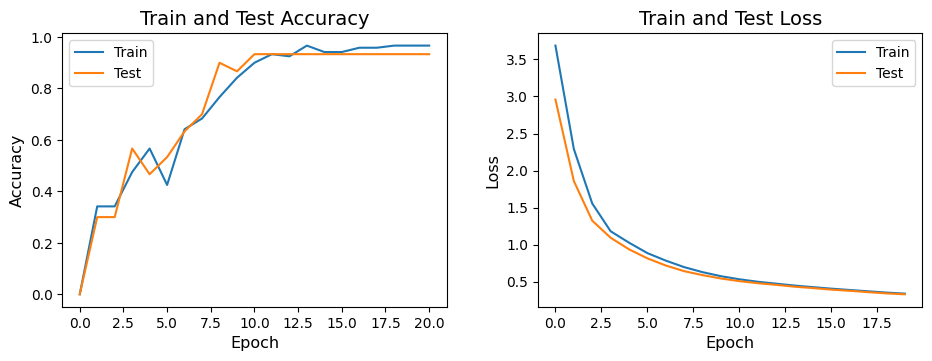

In [ ]:
plot_metrics(metrics_history)

Повторим то же самое, но без скрытых слоёв

In [ ]:
jax.lax.abs

In [ ]:
_, metrics_history, *_ = run(X_train=X_train, 
                             y_train=y_train, 
                             X_test=X_test, 
                             y_test=y_test,
                             batch_size=10,
                             key=jax.random.key(42),
                             input_dim=X_train.shape[1], 
                             hidden=None, 
                             output_dim=3, 
                             num_epochs=20)
                             

[train] eposh: 0, loss: 4.492325305938721, accuracy: 33.333335876464844
[test] epoch: 0, loss: 3.7482786178588867, accuracy: 33.333335876464844
[train] eposh: 1, loss: 3.4115631580352783, accuracy: 33.333335876464844
[test] epoch: 1, loss: 2.723813056945801, accuracy: 33.333335876464844
[train] eposh: 2, loss: 2.5730154514312744, accuracy: 17.5
[test] epoch: 2, loss: 2.124810218811035, accuracy: 6.6666669845581055
[train] eposh: 3, loss: 2.1018826961517334, accuracy: 15.833333015441895
[test] epoch: 3, loss: 1.7381232976913452, accuracy: 36.66666793823242
[train] eposh: 4, loss: 1.7065649032592773, accuracy: 28.33333396911621
[test] epoch: 4, loss: 1.3888511657714844, accuracy: 26.666667938232422
[train] eposh: 5, loss: 1.3793376684188843, accuracy: 20.0
[test] epoch: 5, loss: 1.1716772317886353, accuracy: 26.666667938232422
[train] eposh: 6, loss: 1.1711078882217407, accuracy: 20.0
[test] epoch: 6, loss: 1.0873714685440063, accuracy: 16.666667938232422
[train] eposh: 7, loss: 1.106756

accuracy
loss


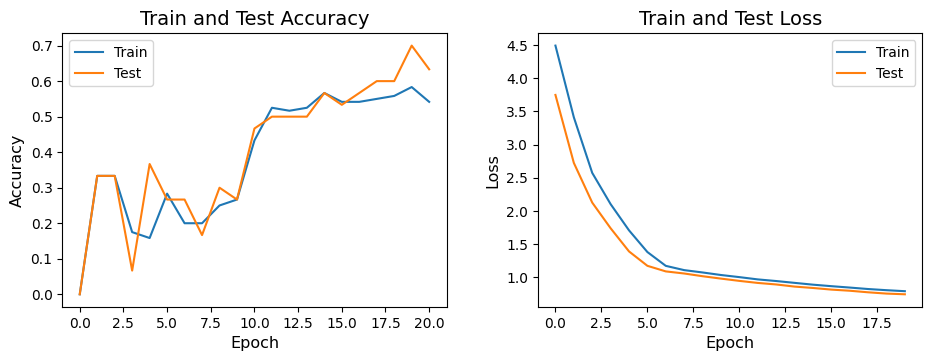

In [ ]:
plot_metrics(metrics_history)

Получилось хуже, попробуем с 3 скрытыми слоями

In [ ]:
_, metrics_history, *_ = run(X_train=X_train, 
                             y_train=y_train, 
                             X_test=X_test, 
                             y_test=y_test,
                             batch_size=10,
                             key=jax.random.key(42),
                             input_dim=X_train.shape[1], 
                             hidden=(3,), 
                             output_dim=3, 
                             num_epochs=20)

[train] eposh: 0, loss: 6.227370738983154, accuracy: 32.5
[test] epoch: 0, loss: 4.6858601570129395, accuracy: 36.66666793823242
[train] eposh: 1, loss: 3.7807254791259766, accuracy: 32.5
[test] epoch: 1, loss: 2.4395296573638916, accuracy: 36.66666793823242
[train] eposh: 2, loss: 2.2329585552215576, accuracy: 42.5
[test] epoch: 2, loss: 1.916079044342041, accuracy: 40.0
[train] eposh: 3, loss: 1.7521461248397827, accuracy: 43.33333206176758
[test] epoch: 3, loss: 1.3411955833435059, accuracy: 70.0
[train] eposh: 4, loss: 1.295115351676941, accuracy: 62.5
[test] epoch: 4, loss: 1.054118275642395, accuracy: 70.0
[train] eposh: 5, loss: 1.0403962135314941, accuracy: 58.33333206176758
[test] epoch: 5, loss: 0.9051437973976135, accuracy: 66.66667175292969
[train] eposh: 6, loss: 0.8914930820465088, accuracy: 63.33333206176758
[test] epoch: 6, loss: 0.8537308573722839, accuracy: 73.33333587646484
[train] eposh: 7, loss: 0.8491433262825012, accuracy: 67.5
[test] epoch: 7, loss: 0.8301259875

accuracy
loss


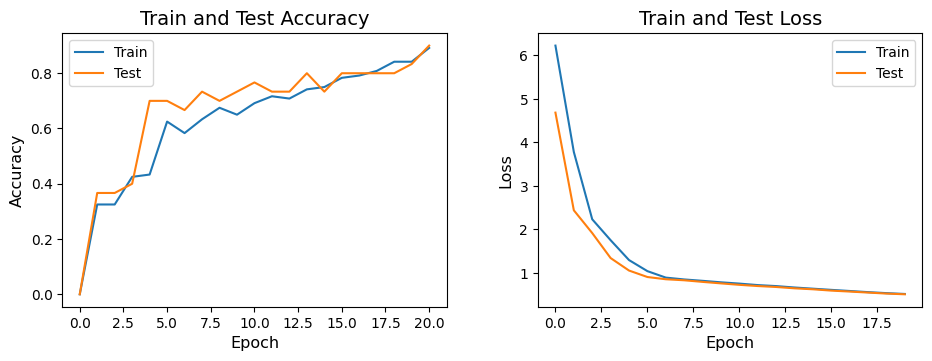

In [ ]:
plot_metrics(metrics_history)

Модель чуть исправилась, но итоговое качество всё равно осталось хуже, чем в первый раз

# Я узнал про jax.example_libraries, так что можно реализовать с их помощью, если продумать подсчёт метрик.

In [11]:
import jax
from jax import numpy as jnp, random as jrd
from jax.example_libraries import stax, optimizers
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import collections.abc as cabc
import functools as ft
import itertools as it

EPOCHS = 10
BATCH_SIZE = 5
LR = 1e-3

init_fn, apply_fn = stax.serial(
    stax.Dense(5), stax.Relu,
    stax.Dense(3), stax.LogSoftmax
)

(opt_init, opt_update, get_params) = optimizers.adam(step_size=LR)

In [22]:
def loss_fn(params: chex.PyTreeDef, batch: tuple[chex.ArrayNumpy]) -> chex.Array:
    X, y = batch
    y = jax.nn.one_hot(y, 3)
    preds = apply_fn(params, X)
    return -jnp.mean(jnp.sum(preds * y, axis=1))

@jax.jit
def accuracy(params: chex.PyTreeDef, batch: tuple[chex.ArrayNumpy]) -> chex.Array:
    inputs, targets = batch
    predicted_class = jnp.argmax(apply_fn(params, inputs), axis=1)
    return jnp.mean(jnp.equal(predicted_class, targets))

@jax.jit
def update(j: int, opt_state: optimizers.State, batch:tuple[chex.ArrayNumpy]) -> optimizers.State:
    params = get_params(opt_state)
    return opt_update(j, jax.grad(loss_fn)(params, batch), opt_state)

def train():
    key = jrd.key(42)
    key, data_key, model_key = jrd.split(key, num=3)

    iris = load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=42)
    num_batches, _ = divmod(X_train.shape[0], BATCH_SIZE)
    def data_stream():
        while True:
            perm = jrd.permutation(data_key, X_train.shape[0])
            for i in range(num_batches):
                batch_idx = perm[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
                yield X_train[batch_idx], y_train[batch_idx]
    batches = data_stream()

    _, params = init_fn(model_key, X_train[0].shape)
    opt_state = opt_init(params)
    itercount = it.count()

    for _ in range(EPOCHS):
        for _ in range(num_batches):
            opt_state = update(next(itercount), opt_state, next(batches))

        train_acc = accuracy(get_params(opt_state), (X_train, y_train))
        test_acc = accuracy(get_params(opt_state), (X_test, y_test))
        print(f"Training set accuracy {train_acc}")
        print(f"Test set accuracy {test_acc}")
    

train()

Training set accuracy 0.3333333432674408
Test set accuracy 0.36666667461395264
Training set accuracy 0.32500001788139343
Test set accuracy 0.36666667461395264
Training set accuracy 0.32500001788139343
Test set accuracy 0.36666667461395264
Training set accuracy 0.31666669249534607
Test set accuracy 0.36666667461395264
Training set accuracy 0.2750000059604645
Test set accuracy 0.36666667461395264
Training set accuracy 0.23333334922790527
Test set accuracy 0.2666666805744171
Training set accuracy 0.24166667461395264
Test set accuracy 0.2666666805744171
Training set accuracy 0.2750000059604645
Test set accuracy 0.36666667461395264
Training set accuracy 0.5083333849906921
Test set accuracy 0.6333333849906921
Training set accuracy 0.6000000238418579
Test set accuracy 0.7000000476837158
